In [2]:
import sympy
import symnum
import symnum.numpy as snp
# import simsde
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import cho_solve
from jax.scipy.special import ndtr, ndtri
from jax import jit, vmap, grad, value_and_grad
from jax.lax import scan
from jax.example_libraries.optimizers import adagrad, adam
import matplotlib.pyplot as plt
from jax.config import config
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [3]:
import sys
print(sys.path)

['/Users/yugaiguchi/Research/Development/GitHub/Dev_Hypo/Untitled/notebooks', '/Users/yugaiguchi/.vscode/extensions/ms-toolsai.jupyter-2022.6.1201981810/pythonFiles', '/Users/yugaiguchi/.vscode/extensions/ms-toolsai.jupyter-2022.6.1201981810/pythonFiles/lib/python', '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python38.zip', '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8', '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Users/yugaiguchi/Library/Python/3.8/lib/python/site-packages', '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/site-packages']


In [4]:

#sys.path.append('/Users/yugaiguchi/Library/Python/3.8/lib/python')
sys.path.append('/Users/yugaiguchi/Research/Development/GitHub/Dev_Hypo/Untitled')
import simsde

## Model functions

In [5]:
# x[0], x[1], x[2]: extended space (rough), x[3]: momentum, x[4]:position
# unit mass (M = 1), d_r = 3, d_X = 5. dim_bm = 3

def drift_position(x, θ):
    return snp.array([x[3]])

def drift_momentum(x, θ):
    λ_1, λ_2, λ_3, *_ = θ
    # the potential function q -> V(q) is assumed to be V(q) = q^2 /2 
    return snp.array([- x[4] + λ_1*x[0] + λ_2*x[1] + λ_3*x[2]])

def diff_coeff_rough(x, θ):
    *_, α_1, α_2, α_3, β = θ
    σ_1 = snp.sqrt(2*α_1/β)
    σ_2 = snp.sqrt(2*α_2/β) 
    σ_3 = snp.sqrt(2*α_3/β) 
    return snp.array([[σ_1, 0, 0], [0, σ_2, 0], [0, 0, σ_3]])

def drift_rough(x, θ):
    λ_1, λ_2, λ_3, α_1, α_2, α_3, *_ = θ
    return snp.array([
        - λ_1*x[3] - α_1*x[0], 
        - λ_2*x[3] - α_2*x[1], 
        - λ_3*x[3] - α_3*x[2]
    ])

def drift_smooth(x, θ):
    return snp.concatenate((drift_momentum(x, θ), drift_position(x, θ)))

def drift_func(x, θ):
    return snp.concatenate((drift_rough(x, θ), drift_smooth(x, θ)))

def diff_coeff(x, θ):
    return snp.concatenate((diff_coeff_rough(x, θ), snp.zeros((dim_x - dim_r, dim_w))), 0)


dim_x = 5
dim_s1 = 1
dim_s2 = 1
dim_r = 3
dim_θ = 7


## Simulating paths

In [6]:
dim_n, step_func = {
    "euler_maruyama": (
        dim_r,
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
    ),
    "local_gaussian_ii": (
        3*dim_r,
        simsde.integrators.hypoelliptic_ii_local_gaussian_step(drift_func, drift_rough, drift_position, drift_momentum, diff_coeff_rough)
    )
}["local_gaussian_ii"]

jax_step_func = symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)


In [7]:
@jit
def simulate_diffusion(x_0, θ, t_seq, n_seq):
    
    def step_func(x, n_dt):
        n, dt = n_dt
        x_next = jax_step_func(x, θ, n, dt)
        return x_next, x_next
    
    _, x_seq = scan(step_func, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
    
    return jnp.concatenate((x_0[None], x_seq))

vmapped_simulate_diffusion = jit(vmap(simulate_diffusion, (None, None, None, 0)))

In [8]:
rng = np.random.default_rng(20230303)
dt = 1e-5
t_min = 0
t_max = 20
x_0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

t_seq_sim = np.arange(int(t_max / dt) + 1) * dt

parameter_values = {
    "λ_1": 0.5,
    "λ_2": 1.0,
    "λ_3": 2.0, 
    "α_1": 1.0, 
    "α_2": 4.0,
    "α_3": 2.0, 
    "β": 1.0 
}
θ_true = np.array(list(parameter_values.values()))

n_seqs = rng.standard_normal((20, t_seq_sim.shape[0] - 1, dim_n))
x_seqs_sim = vmapped_simulate_diffusion(x_0, θ_true, t_seq_sim, n_seqs)

t_seq = t_seq_sim[int(t_min / dt):]
x_seqs = x_seqs_sim[:, int(t_min / dt):]

Text(0.5, 0, 'Time')

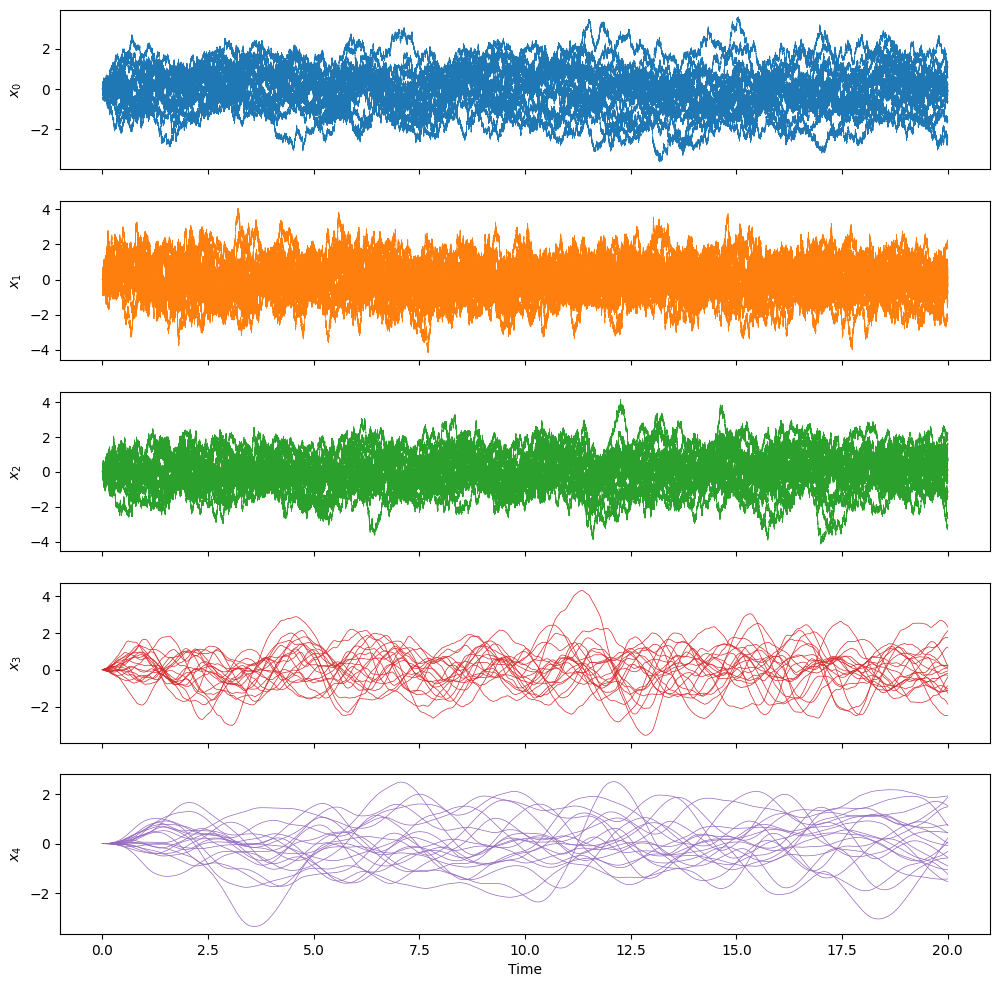

In [9]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = [f'$x_{i}$' for i in range(dim_x)]
for i, ax in enumerate(axes):
    ax.plot(t_seq, x_seqs[:, :, i].T, color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')

## Approximate transition densities

In [10]:
symolic_log_transition_density_generators = {
    'local_gaussian (p = 2)': simsde.densities.local_gaussian_log_transition_density_ii,
}
jax_log_transition_densities = {
    key: symnum.numpify(dim_x, dim_x, dim_θ, None, numpy_module=jnp)(
        symbolic_transition_density_generator(
            drift_position, drift_momentum, drift_rough, diff_coeff_rough
        )
    )
    for key, symbolic_transition_density_generator in 
    symolic_log_transition_density_generators.items()
}

## Log-likelihood functions

In [12]:
def logit(u):
    return jnp.log(u / (1 - u))
    
def sigmoid(u):
    return 1 / (1 + jnp.exp(-u))

free_parameter_ranges = {
    "λ_1": (0.0, 20.0), 
    "λ_2": (0.0, 20.0), 
    "λ_3": (0.0, 20.0), 
    "α_1": (0.1, 10.0),  
    "α_2": (0.1, 30.0),  
    "α_3": (0.1, 30.0),  
    #"β": (0.01, .0), 
}

def generate_θ(u, parameter_values, free_parameter_ranges):
    params = parameter_values.copy()
    for i, (name, (lower, upper)) in enumerate(free_parameter_ranges.items()):
        params[name] = lower + ndtr(u[i]) * (upper - lower)
    return jnp.array(list(params.values()))


def inv_generate_θ(θ, parameter_values, free_parameter_ranges):
    params = {name: value for name, value in zip(parameter_values.keys(), θ)}
    return jnp.array(
        [
            ndtri((params[name] - lower) / (upper - lower))
            for name, (lower, upper) in free_parameter_ranges.items()
        ]
    )

def get_log_likelihood_functions(
    log_transition_density, parameter_values, free_parameter_ranges
):

    @jit
    def log_likelihood_θ(θ, x_seq, t_seq):
        log_transition_density_terms = vmap(log_transition_density, (0, 0, None, 0))(
            x_seq[1:], x_seq[:-1], θ, t_seq[1:] - t_seq[:-1]
        )
        return log_transition_density_terms.sum()
        
    @jit
    def log_likelihood_u(u, x_seq, t_seq):
        return log_likelihood_θ(
            generate_θ(u, parameter_values, free_parameter_ranges), x_seq, t_seq
        )
        
    return {'u': log_likelihood_u, 'θ': log_likelihood_θ}


In [24]:
def plot_log_likelihood(
    log_likelihood, x_seq, t_seq, parameter_values, free_parameter_ranges, n_grid=101
):
    vmapped_log_likelihood_θ = jit(vmap(log_likelihood["θ"], (0, None, None)))
    vmapped_generate_θ = vmap(
        lambda u: generate_θ(u, parameter_values, free_parameter_ranges)
    )
    
    def parameter_and_log_likelihood_grids(u_ranges):
        u_grid = np.stack(np.meshgrid(*u_ranges), -1).reshape((-1, n_free_parameters))
        θ_grid = vmapped_generate_θ(u_grid)
        log_likelihood_grid = vmapped_log_likelihood_θ(θ_grid, x_seq, t_seq)
        return u_grid, θ_grid, log_likelihood_grid

    n_free_parameters = len(free_parameter_ranges)
    fig, axes = plt.subplots(
        2 * n_free_parameters, 
        n_free_parameters, 
        figsize=(n_free_parameters * 4, n_free_parameters * 8)
    )
    axes_u, axes_θ = axes[:n_free_parameters], axes[n_free_parameters:]
    parameter_names = list(parameter_values.keys())
    θ_free_indices = [parameter_names.index(name) for name in free_parameter_ranges]
    θ_true = list(parameter_values.values())
    u_true = inv_generate_θ(θ_true, parameter_values, free_parameter_ranges)
    for u_index_1, θ_index_1 in enumerate(θ_free_indices):
        u_ranges = list(u_true)
        u_ranges[u_index_1] = np.linspace(-3, 3, n_grid)
        u_grid, θ_grid, log_likelihood_grid = parameter_and_log_likelihood_grids(u_ranges)
        for ax, param_label, param_grid, param_true, param_index in [
            (axes_u[u_index_1, u_index_1], "u", u_grid, u_true, u_index_1),
            (axes_θ[u_index_1, u_index_1], "\\theta", θ_grid, θ_true, θ_index_1),
        ]:
            ax.autoscale(True, tight=True)
            ax.plot(param_grid[:, param_index], log_likelihood_grid)
            ax.plot(
                [param_true[param_index], param_true[param_index]],
                ax.get_ylim(),
                '--'
            )
            ax.set(
                xlabel=f"${param_label}_{{{param_index}}}$", ylabel="Log-likelihood"
            )
        for u_index_2, θ_index_2 in enumerate(θ_free_indices):
            if u_index_2 >= u_index_1:
                if u_index_2 > u_index_1:
                    axes_u[u_index_1, u_index_2].set_axis_off()
                    axes_θ[u_index_1, u_index_2].set_axis_off()
                continue
            u_ranges[u_index_2] = np.linspace(-3, 3, n_grid)
            u_grid, θ_grid, log_likelihood_grid = parameter_and_log_likelihood_grids(u_ranges)
            for ax, param_label, param_grid, param_index_1, param_index_2 in [
              (axes_u[u_index_1, u_index_2], "u", u_grid, u_index_1, u_index_2),
              (axes_θ[u_index_1, u_index_2], "\\theta", θ_grid, θ_index_1, θ_index_2),
            ]:
                ax.pcolormesh(
                    param_grid[:, param_index_2].reshape((n_grid, n_grid)),
                    param_grid[:, param_index_1].reshape((n_grid, n_grid)),
                    log_likelihood_grid.reshape((n_grid, n_grid)),
                )
                ax.set(
                    xlabel=f"${param_label}_{{{param_index_2}}}$", 
                    ylabel=f"${param_label}_{{{param_index_1}}}$"
                )
            u_ranges[u_index_2] = u_true[u_index_2]
    return fig, axes         


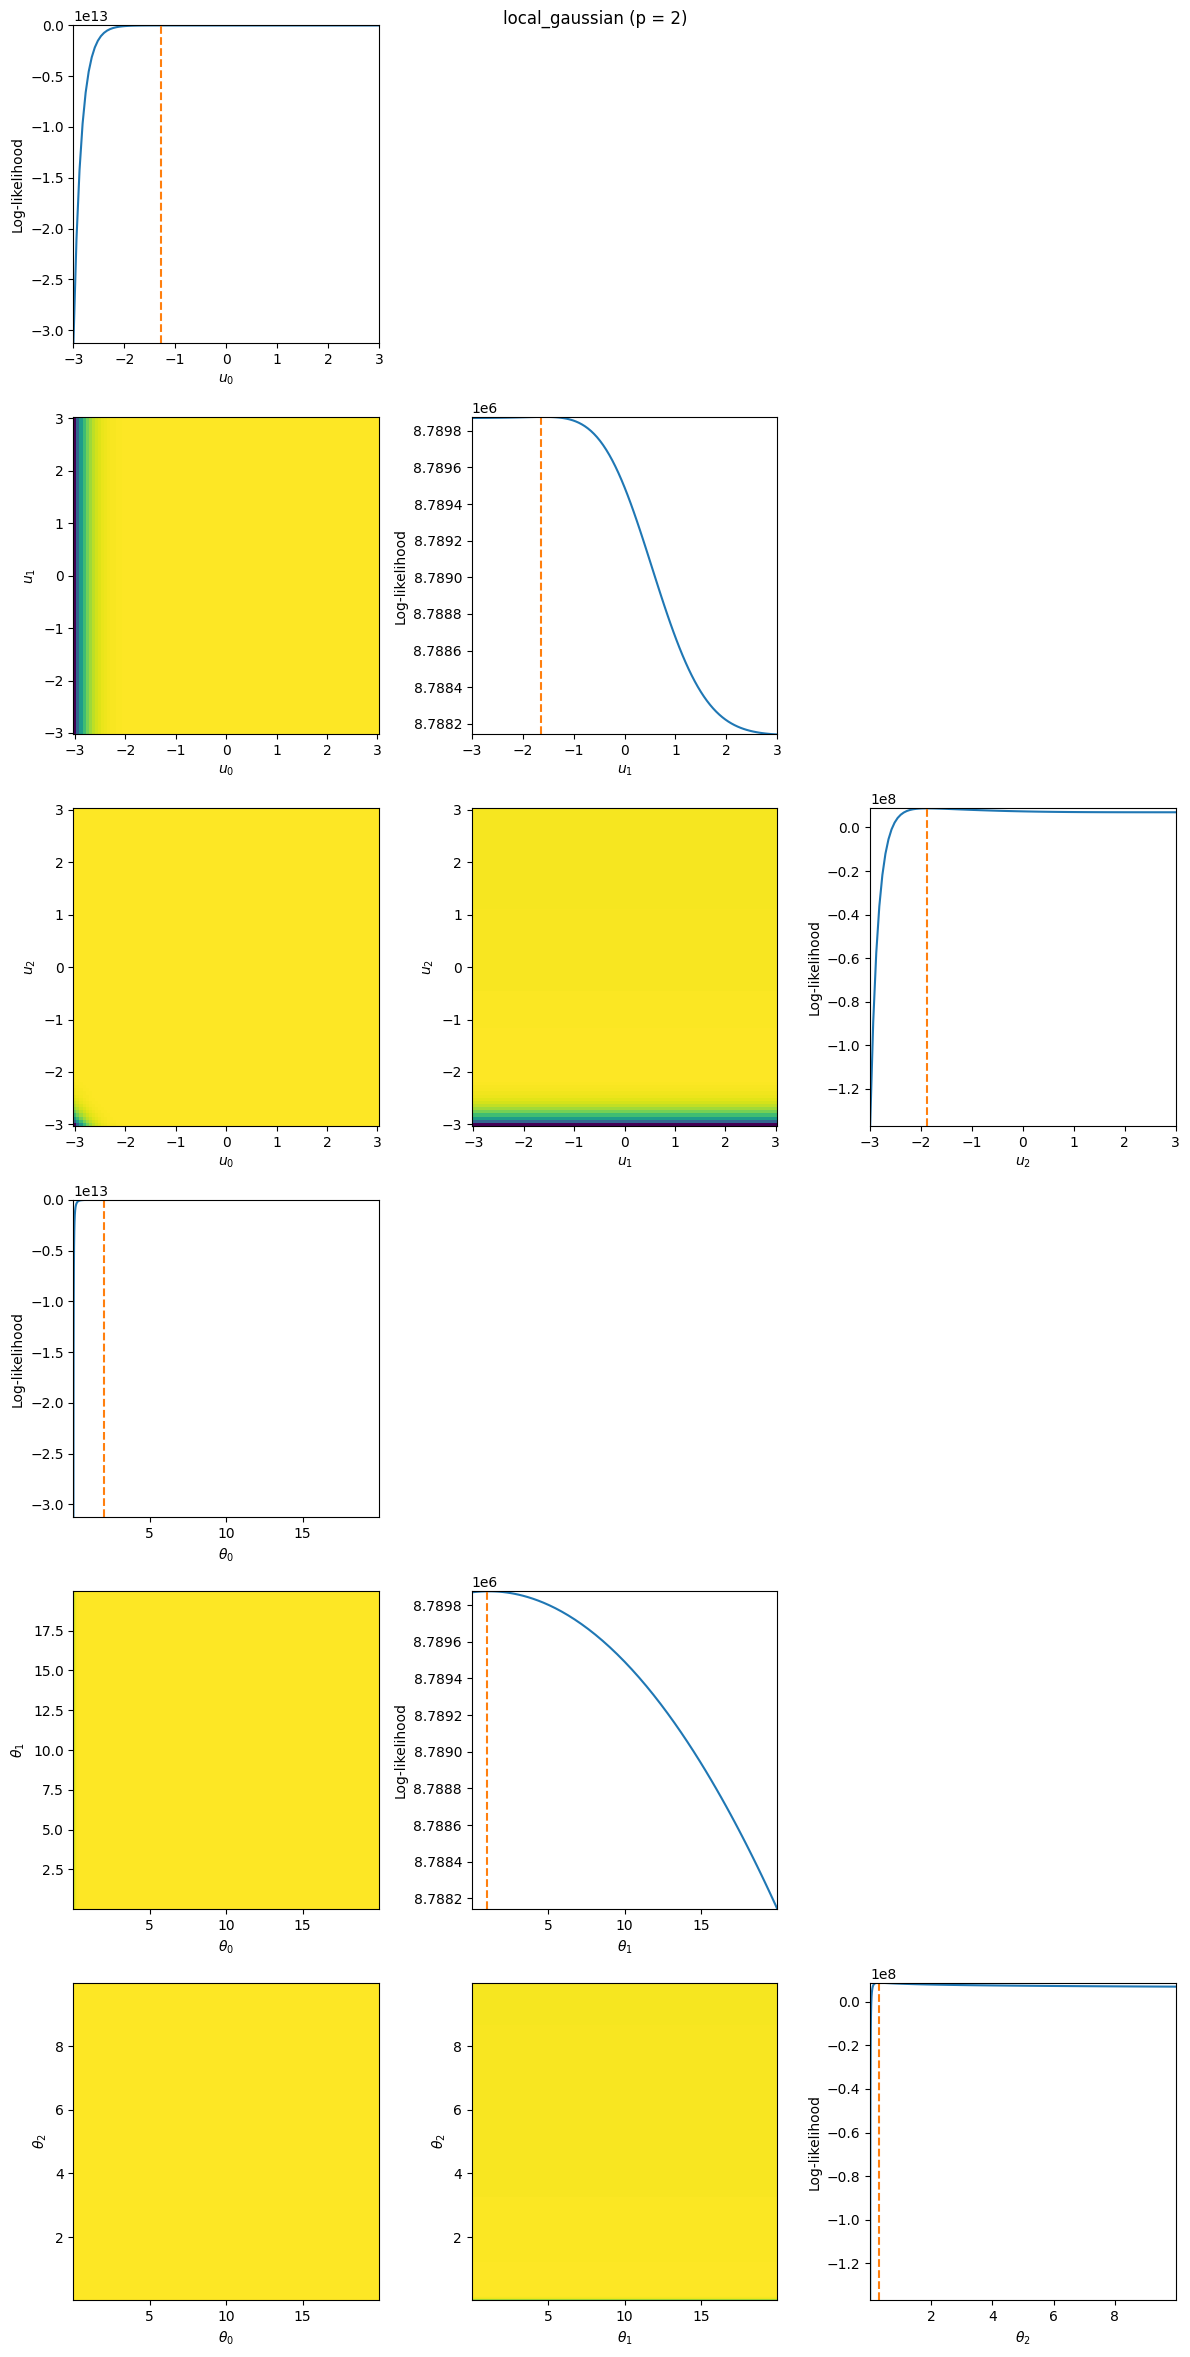

In [14]:
for scheme, log_transition_density in jax_log_transition_densities.items():
    log_likelihood = get_log_likelihood_functions(
        log_transition_density, parameter_values, free_parameter_ranges
    )
    fig, axes = plot_log_likelihood(
        log_likelihood, x_seqs[0], t_seq, parameter_values, free_parameter_ranges
    )
    fig.suptitle(scheme)
    fig.tight_layout()
    

## Convergence of maximum likelihood estimates with time step

Computing ML estimates for local_gaussian (p = 2) scheme with Δt=0.16
λ1 ml estimate: mean = 0.5147945704394207, stdev = 0.05273891110726623 
λ2 ml estimate: mean = 1.0061075260088583, stdev = 0.04740718158065701 
λ3 ml estimate: mean = 2.0045775139544912, stdev = 0.037501841274895406 
α1 ml estimate: mean = 0.8337263605767365, stdev = 0.09154179847306834 
α2 ml estimate: mean = 2.5863547063624455, stdev = 0.22871177722931083 
α3 ml estimate: mean = 1.898083240190279, stdev = 0.15788731721743196 
β ml estimate: mean = 1.0, stdev = 0.0 
[[0.47811224 1.06557911 1.96748233 0.84753185 2.57558846 2.22596368
  1.        ]
 [0.53190555 0.97798678 1.95114004 0.74415447 2.58225973 1.93019986
  1.        ]
 [0.49112386 0.98628321 2.01292575 0.76155661 2.45981643 1.9525099
  1.        ]
 [0.59549918 1.00025998 1.94760572 0.69968781 2.46149804 1.98596855
  1.        ]
 [0.59850958 0.99203503 2.01623321 0.72440166 2.7760745  1.75549599
  1.        ]
 [0.45175331 0.91821052 2.08248026 0.75603949 2.1

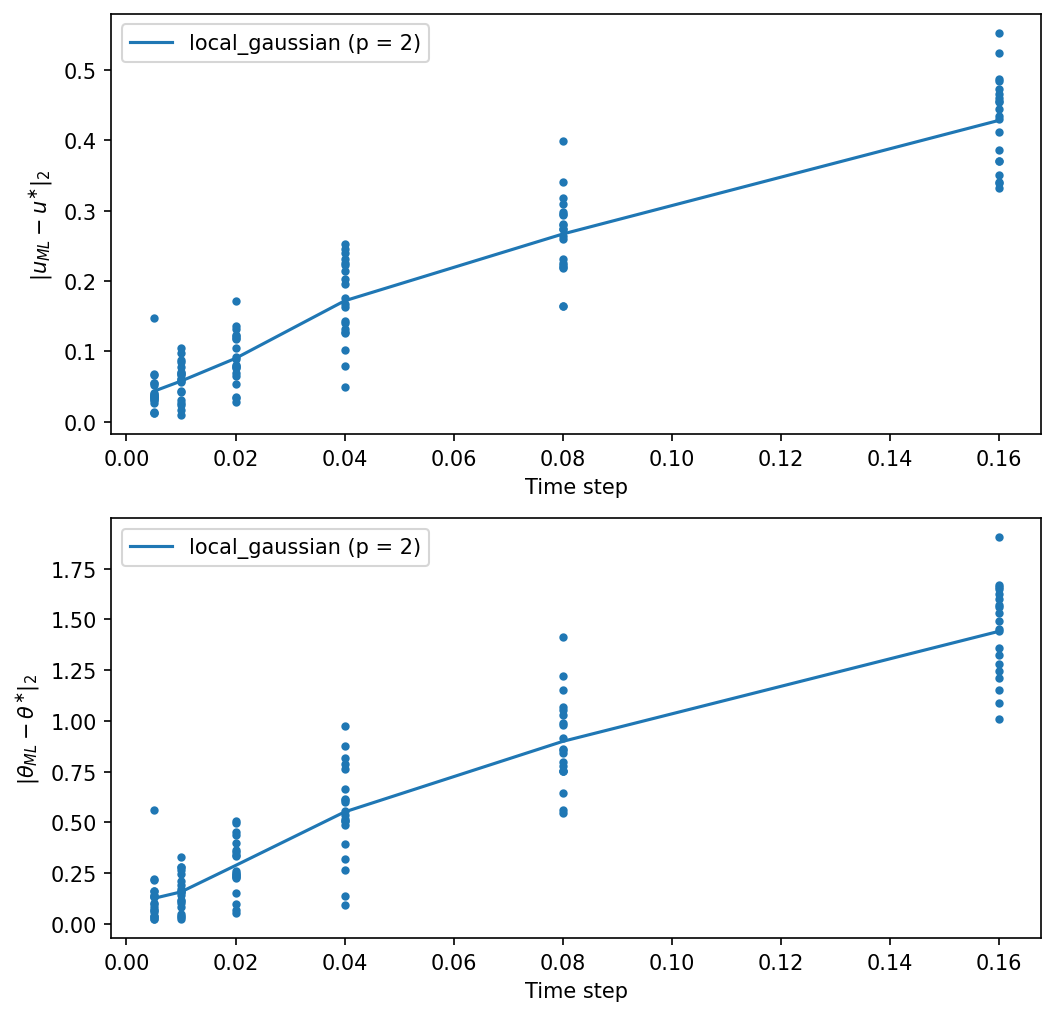

In [14]:
def compute_maximum_likelihood_estimates(
    log_likelihood, t_seq, x_seqs, u_inits, optimizer=adam, n_steps=5000, step_size=1e-2
):
    optimizer_init, optimizer_update, optimizer_get_params = optimizer(step_size)
    
    def optimizer_step(step_index, state, x_seq, t_seq):
        value, grad = value_and_grad(log_likelihood["u"])(
            optimizer_get_params(state), x_seq, t_seq
        )
        state = optimizer_update(step_index, -grad, state)
        return value, state

    vmapped_optimizer_step = jit(vmap(optimizer_step, (None, 0, 0, None)))
    
    state = vmap(optimizer_init)(u_inits)

    for s in range(n_steps):
        _, state = vmapped_optimizer_step(s, state, x_seqs, t_seq)
        
    return optimizer_get_params(state)
    
vmapped_generate_θ = vmap(
    lambda u: generate_θ(u, parameter_values, free_parameter_ranges)
)

seed = 20230303
rng = np.random.default_rng(seed)
u_inits = rng.standard_normal(size=(len(x_seqs), len(free_parameter_ranges)))
θ_true = np.array(list(parameter_values.values()))
u_true = inv_generate_θ(θ_true, parameter_values, free_parameter_ranges)
# subsample_factors = np.array([1000, 500, 200, 100, 50, 20, 10])
subsample_factors = np.array([16000, 8000, 4000, 2000, 1000, 500])
time_steps = (t_seq[-1] - t_seq[0]) / ((t_seq.shape[0] - 1) / subsample_factors)
distances = {
    scheme: {k: np.full((len(subsample_factors), len(x_seqs)), np.nan) for k in "uθ"}
    for scheme in jax_log_transition_densities
}
for scheme, log_transition_density in jax_log_transition_densities.items():
    log_likelihood = get_log_likelihood_functions(
        log_transition_density, parameter_values, free_parameter_ranges
    )
    for i, subsample in enumerate(subsample_factors):
        print(f"Computing ML estimates for {scheme} scheme with Δt={time_steps[i]}")
        u_ml_estimates = compute_maximum_likelihood_estimates(
            log_likelihood, t_seq[::subsample], x_seqs[:, ::subsample], u_inits
        )
        θ_ml_estimates = vmapped_generate_θ(u_ml_estimates)
        distances[scheme]["u"][i] = ((u_ml_estimates - u_true)**2).sum(-1)**0.5
        distances[scheme]["θ"][i] = ((θ_ml_estimates - θ_true)**2).sum(-1)**0.5
        λ1_estimate = θ_ml_estimates[:, 0] 
        λ2_estimate = θ_ml_estimates[:, 1] 
        λ3_estimate = θ_ml_estimates[:, 2] 
        α1_estimate = θ_ml_estimates[:, 3]
        α2_estimate = θ_ml_estimates[:, 4]
        α3_estimate = θ_ml_estimates[:, 5] 
        β_estimate = θ_ml_estimates[:, 6]
        distances[scheme]["u"][i] = ((u_ml_estimates - u_true)**2).sum(-1)**0.5
        distances[scheme]["θ"][i] = ((θ_ml_estimates - θ_true)**2).sum(-1)**0.5
        print(f"λ1 ml estimate: mean = {λ1_estimate.mean(-1)}, stdev = {λ1_estimate.std(-1)} ")
        print(f"λ2 ml estimate: mean = {λ2_estimate.mean(-1)}, stdev = {λ2_estimate.std(-1)} ")
        print(f"λ3 ml estimate: mean = {λ3_estimate.mean(-1)}, stdev = {λ3_estimate.std(-1)} ")
        print(f"α1 ml estimate: mean = {α1_estimate.mean(-1)}, stdev = {α1_estimate.std(-1)} ")
        print(f"α2 ml estimate: mean = {α2_estimate.mean(-1)}, stdev = {α2_estimate.std(-1)} ") 
        print(f"α3 ml estimate: mean = {α3_estimate.mean(-1)}, stdev = {α3_estimate.std(-1)} ")
        print(f"β ml estimate: mean = {β_estimate.mean(-1)}, stdev = {β_estimate.std(-1)} ")
        distances[scheme]["u"][i] = ((θ_ml_estimates/θ_true - 1)**2).sum(-1)**0.5 
        distances[scheme]["θ"][i] = ((θ_ml_estimates - θ_true)**2).sum(-1)**0.5
        print(θ_ml_estimates)
        

fig, axes = plt.subplots(2, figsize=(8, 8), dpi=150)
for ax, parameterization in zip(axes, "uθ"):
    for scheme, color in zip(jax_log_transition_densities, ("C0", "C1")):
        ax.plot(time_steps, distances[scheme][parameterization], '.', color=color)
        ax.plot(
            time_steps, 
            distances[scheme][parameterization].mean(-1), 
            '-', 
            color=color, 
            label=scheme
        )
    ax.set(
        xlabel='Time step', 
        ylabel=f'$\\|{parameterization}_{{ML}} - {parameterization}^{{\\ast}}\\|_2$'
    )
    ax.legend()